# Lale: Type-Driven Auto-ML with Scikit-Learn

### https://github.com/ibm/lale

### Example Dataset

In [1]:
!pip install 'liac-arff>=2.4.0'

You should consider upgrading via the '/Users/kakateus.ibm.com/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=False)
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index).tail(),
           train_X.tail()], axis=1)

,y,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
835,0,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,...,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,0,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,...,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,1,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,...,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,0,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,...,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,1,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,...,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


### Algorithm Selection and Hyperparameter Tuning

In [3]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import OneHotEncoder as OneHot
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBoost
from sklearn.svm import LinearSVC
from lale.operators import make_pipeline, make_union
from lale.lib.lale import Project, ConcatFeatures, NoOp
lale.wrap_imported_operators()

/Users/kakateus.ibm.com/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/kakateus.ibm.com/anaconda3/lib/python3.7/site-packages/pyparsing.py:3174: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


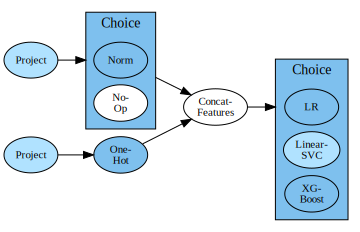

In [4]:
project_nums = Project(columns={'type': 'number'})
project_cats = Project(columns={'type': 'string'})
planned_pipeline = (
       (project_nums >> (Norm | NoOp) & project_cats >> OneHot)
    >> ConcatFeatures
    >> (LR | LinearSVC(dual=False)| XGBoost))
planned_pipeline.visualize()

In [5]:
import sklearn.metrics
from lale.lib.lale import Hyperopt
auto_optimizer = Hyperopt(estimator=planned_pipeline, cv=3, max_evals=5)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')

100%|██████████| 5/5 [00:50<00:00, 10.07s/trial, best loss: -0.7492325966260944]
accuracy 71.8%


### Displaying Automation Results

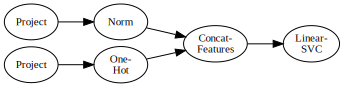

In [6]:
best_pipeline = auto_trained.get_pipeline()
best_pipeline.visualize()

In [7]:
from lale.pretty_print import ipython_display
ipython_display(best_pipeline, show_imports=False)

```python
project_0 = Project(columns={"type": "number"})
norm = Norm(norm="l1")
project_1 = Project(columns={"type": "string"})
linear_svc = LinearSVC(
    dual=False,
    C=16757.615906506046,
    fit_intercept=False,
    tol=0.0006905134087360421,
)
pipeline = (
    ((project_0 >> norm) & (project_1 >> OneHot()))
    >> ConcatFeatures()
    >> linear_svc
)
```

### JSON Schemas

https://json-schema.org/

In [8]:
ipython_display(XGBoost.hyperparam_schema('n_estimators'))

```python
{
    "description": "Number of trees to fit.",
    "type": "integer",
    "default": 1000,
    "minimumForOptimizer": 500,
    "maximumForOptimizer": 1500,
}
```

In [9]:
ipython_display(XGBoost.hyperparam_schema('booster'))

```python
{
    "description": "Specify which booster to use.",
    "enum": ["gbtree", "gblinear", "dart"],
    "default": "gbtree",
}
```

In [10]:
import jsonschema
import sys
try:
    XGBoost(n_estimators=0.5, booster='gbtree')
except jsonschema.ValidationError as e:
    print(e.message, file=sys.stderr)

Invalid configuration for XGBoost(n_estimators=0.5, booster='gbtree') due to invalid value n_estimators=0.5.
Schema of argument n_estimators: {
    "description": "Number of trees to fit.",
    "type": "integer",
    "default": 1000,
    "minimumForOptimizer": 500,
    "maximumForOptimizer": 1500,
}
Value: 0.5


### Customizing Schemas

In [11]:
import lale.schemas as schemas
Grove = XGBoost.customize_schema(
    n_estimators=schemas.Int(min=2, max=10),
    booster=schemas.Enum(['gbtree'], default='gbtree'))

In [12]:
grove_planned = ( Project(columns={'type': 'number'}) >> Norm
                & Project(columns={'type': 'string'}) >> OneHot
                ) >> ConcatFeatures >> Grove

In [13]:
grove_optimizer = Hyperopt(estimator=grove_planned, cv=3, max_evals=10)
grove_trained = grove_optimizer.fit(train_X, train_y)
grove_y = grove_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, grove_y):.1%}')

100%|██████████| 10/10 [00:42<00:00,  4.28s/trial, best loss: -0.7433202541106129]
accuracy 73.9%


In [14]:
grove_best = grove_trained.get_pipeline()
ipython_display(grove_best, show_imports=False)

```python
project_0 = Project(columns={"type": "number"})
norm = Norm(norm="l1")
project_1 = Project(columns={"type": "string"})
xg_boost = XGBoost(
    gamma=0.5347651601211355,
    learning_rate=0.4698440238677895,
    max_depth=9,
    min_child_weight=16,
    n_estimators=4,
    reg_alpha=0.16360717863855023,
    reg_lambda=0.9454327638424944,
    subsample=0.7366877378057126,
)
pipeline = (
    ((project_0 >> norm) & (project_1 >> OneHot()))
    >> ConcatFeatures()
    >> xg_boost
)
```

### Human-in-the-Loop Auto-ML

### https://github.com/ibm/lale

<img src="img/2019-1208-loops.png" style="width:700px" align="left">